In [1]:
#this is the main file


#importing required libraries

from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs, log
from matplotlib.pyplot import plot, scatter, loglog


#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

called gridmd
called constantmd
called functionsmd
-----------start-----------


In [2]:
#N = N_xyz(10,6,6)
coor_0 = initialPos(N,ial)
xyz_grid = xyzGrid(coor_0[0], coor_0[1], coor_0[2])

In [3]:
time_grid = np.empty([N_steps,N[0],N[1],N[2],3])
time_grid[0] = np.array([xyz_grid])

force_grid = np.zeros([N_steps, N[0], N[1], N[2],3])

In [4]:
#%%timeit
t=0
for t in range(N_steps):
    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                #fx = forceXLJ3(i,j,k)
                #fy = forceYLJ3(i,j,k)
                #fz = forceZLJ3(i,j,k)
                fx, fy, fz = forceLJ3(i, j, k, xyz_grid)
                acc = (fx/mass)#+FaByMass
                xj=verlet_pos(time_grid[t][i][j][k][0],t,ts,acc)
                yj=verlet_pos(time_grid[t][i][j][k][1], t, ts, 
                              fy/mass)
                zj=verlet_pos(time_grid[t][i][j][k][2], t, ts, 
                              fz/mass)
                time_grid[t][i][j][k][0] = xj
                time_grid[t][i][j][k][1] = yj
                time_grid[t][i][j][k][2] = zj
                
                force_grid[t][i][j][k][0] = fx;force_grid[t][i][j][k][1] = fy;force_grid[t][i][j][k][2] = fz

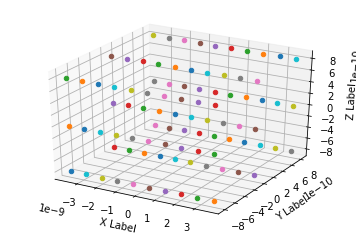

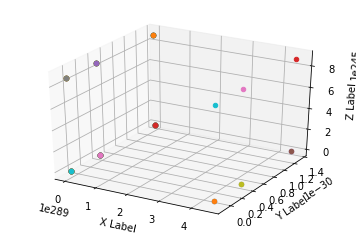

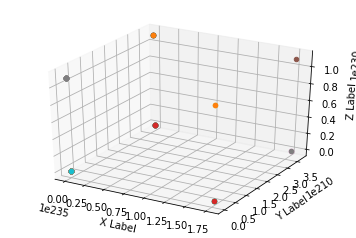

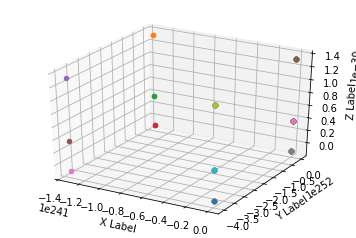

In [5]:
time=0
fig0 = plt.figure()
ax = fig0.add_subplot(111, projection='3d')
for i in time_grid[time,:,0,0,0]:
    for j in time_grid[time,0,:,0,1]:
        for k in time_grid[time,0,0,:,2]:
            ax.scatter(i,j,k)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

time=1
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
for i in time_grid[time,:,0,0,0]:
    for j in time_grid[time,0,:,0,1]:
        for k in time_grid[time,0,0,:,2]:
            ax.scatter(i,j,k)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

time=2
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
for i in time_grid[time,:,0,0,0]:
    for j in time_grid[time,0,:,0,1]:
        for k in time_grid[time,0,0,:,2]:
            ax.scatter(i,j,k)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

time=3
fig3 = plt.figure()
ax = fig3.add_subplot(111, projection='3d')
for i in time_grid[time,:,0,0,0]:
    for j in time_grid[time,0,:,0,1]:
        for k in time_grid[time,0,0,:,2]:
            ax.scatter(i,j,k)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [6]:
def timeForceMeanAndTimeStress():
    time_forceMean = np.zeros([N_steps, 3])
    time_stress = np.zeros([N_steps, 3])
    fxMean = 0;fyMean = 0;fzMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    fxMean+=force_grid[t][i][j][k][0]
                    fyMean+=force_grid[t][i][j][k][1]
                    fzMean+=force_grid[t][i][j][k][2]
        fxMean = fxMean/N[0];fyMean = fyMean/N[1];fzMean = fzMean/N[2];
        time_stress[t] = np.array([fxMean/(N[1]*N[2]*ial**2), fyMean/(N[2]*N[0]*ial**2), fzMean/(N[1]*N[0]*ial**2)])
        time_forceMean[t] = np.array([fxMean, fyMean, fzMean])
    return time_forceMean, time_stress

In [7]:
time_forceMean, time_stress = timeForceMeanAndTimeStress()

In [8]:
time_stress[:,0]

array([ -2.75740149e-14,  -3.03314164e-14,  -3.06071565e-14,
        -3.06347305e-14,  -3.06374879e-14,  -3.06377637e-14,
        -3.06377912e-14,  -3.06377940e-14,  -3.06377943e-14,
        -3.06377943e-14])

In [9]:
strainXYZ = np.zeros([N[0], N[1], N[2], 3])
time_strainXYZ = np.zeros([N_steps, N[0], N[1], N[2], 3])
time_strainXYZ[0] = strainXYZ
for t in range(N_steps):
    if t==0:
        pass #strainX[t] = 0
    else:
        strainXYZ = abs(time_grid[t]-time_grid[0])/ial
        time_strainXYZ[t] = strainXYZ

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in true_divide
  


In [10]:
#time_strainMean = np.zeros([N_steps, 3])

In [11]:
def timeStrainMean():
    time_strainMean = np.zeros([N_steps, 3])
    StrainXMean = 0;StrainYMean = 0;StrainZMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    StrainXMean+=time_strainXYZ[t][i][j][k][0]
                    StrainYMean+=time_strainXYZ[t][i][j][k][1]
                    StrainZMean+=time_strainXYZ[t][i][j][k][2]
        StrainXMean = StrainXMean/N[0];StrainYMean = StrainYMean/N[1];StrainZMean = StrainZMean/N[2];
        time_strainMean[t] = np.array([StrainXMean, StrainYMean, StrainZMean])
    return time_strainMean

In [12]:
time_strainMean = timeStrainMean()
print(time_strainMean)

[[  0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.63696238e+298   5.11416454e+298               inf]
 [  1.63696396e+297   1.70472209e+298               inf]
 [  4.56095066e+304   1.06806882e+303               inf]
 [  4.56095066e+303   3.56065938e+302               inf]
 [  4.56095066e+302   1.18756195e+302               inf]
 [  1.83816260e+305   6.11936735e+305               inf]
 [  4.28867697e+304   2.03979619e+305               inf]
 [  4.28867697e+303   6.79936879e+304               inf]
 [  2.84311689e+303   5.61348999e+304               inf]]


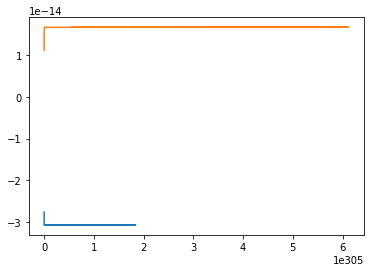

In [18]:
plot(time_strainMean, time_stress)

In [20]:
for i in range(N_steps):
    print(time_stress[i][0]/time_strainMean[i][0])

-inf
-1.85290858391e-312
-1.86975139156e-311
-6.71672364208e-319
-6.7173461648e-318
-6.71740742894e-317
-1.66677986281e-319
-7.14389279948e-319
-7.14387797751e-318
-1.077613003e-317


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

"""import os
os.system('spd-say "your program is finished"')"""

'import os\nos.system(\'spd-say "your program is finished"\')'

In [16]:
print("------------end------------")

------------end------------
